In [ ]:
import os
import glob
import json
import time
import requests
import datetime
import dateutil
import pandas as pd
import re
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.models import load_model
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
end = datetime.date.today()
start = end - relativedelta(years=4)
print(end, start)

2021-05-16 2017-05-16


In [ ]:
months_in_range = [x.split(' ') for x in pd.date_range(start, end, freq='MS').strftime("%Y %-m").tolist()]
print(months_in_range)

[['2017', '6'], ['2017', '7'], ['2017', '8'], ['2017', '9'], ['2017', '10'], ['2017', '11'], ['2017', '12'], ['2018', '1'], ['2018', '2'], ['2018', '3'], ['2018', '4'], ['2018', '5'], ['2018', '6'], ['2018', '7'], ['2018', '8'], ['2018', '9'], ['2018', '10'], ['2018', '11'], ['2018', '12'], ['2019', '1'], ['2019', '2'], ['2019', '3'], ['2019', '4'], ['2019', '5'], ['2019', '6'], ['2019', '7'], ['2019', '8'], ['2019', '9'], ['2019', '10'], ['2019', '11'], ['2019', '12'], ['2020', '1'], ['2020', '2'], ['2020', '3'], ['2020', '4'], ['2020', '5'], ['2020', '6'], ['2020', '7'], ['2020', '8'], ['2020', '9'], ['2020', '10'], ['2020', '11'], ['2020', '12'], ['2021', '1'], ['2021', '2'], ['2021', '3'], ['2021', '4'], ['2021', '5']]


In [ ]:
def send_request(date):
    '''Sends a request to the NYT Archive API for given date.'''
    base_url = 'https://api.nytimes.com/svc/archive/v1/'
    url = base_url  + date[0] + '/' + date[1] + '.json?api-key=' + '5bBmcpCW4fOGtnBURGCXLoVFo887iwWX'
    response = requests.get(url).json()
    time.sleep(6)
    return response


def is_valid(article, date):
    '''An article is only worth checking if it is in range, and has a headline.'''
    is_in_range = date > start and date < end
    has_headline = type(article['headline']) == dict and 'main' in article['headline'].keys()
    return is_in_range and has_headline


def parse_response(response):
    '''Parses and returns response as pandas data frame.'''
    data = {'headline': [],  
        'date': [], 
        'doc_type': [],
        'material_type': [],
        'section': [],
        'news_desk':[],
        'abstract':[],
        'keywords': [],
        'lead_paragraph':[],
        'snippet':[]}
    
    articles = response['response']['docs'] 

    for article in articles: 
        date = dateutil.parser.parse(article['pub_date']).date()
        if is_valid(article, date):
            data['date'].append(date)
            data['headline'].append(article['headline']['main']) 
            if 'section_name' in article:
                data['section'].append(article['section_name'])
            else:
                data['section'].append(None)
            data['doc_type'].append(article['document_type'])
            if 'type_of_material' in article: 
                data['material_type'].append(article['type_of_material'])
            else:
                data['material_type'].append(None)
            if 'abstract' in article: 
                data['abstract'].append(article['abstract'])
            else:
                data['abstract'].append(None)
            if 'news_desk' in article: 
                data['news_desk'].append(article['news_desk'])
            else:
                data['news_desk'].append(None)
            if 'lead_paragraph' in article: 
                data['lead_paragraph'].append(article['lead_paragraph'])
            else:
                data['lead_paragraph'].append(None)
            if 'snippet' in article: 
                data['snippet'].append(article['snippet'])
            else:
                data['snippet'].append(None)
            keywords = [keyword['value'] for keyword in article['keywords'] if keyword['name'] == 'subject']
            new_keywords = listToString(keywords)
            data['keywords'].append(new_keywords)
    return pd.DataFrame(data) 

def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += (ele+",")  
    return str1

def word_cloud(text,color):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color=color).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def get_data(dates):
    '''Sends and parses request/response to/from NYT Archive API for given dates.'''
    total = 0
    print('Date range: ' + str(dates[0]) + ' to ' + str(dates[-1]))
    if not os.path.exists('headlines'):
        os.mkdir('headlines')
    for date in dates:
        response = send_request(date)
        df = parse_response(response)
        total += len(df)
        df.to_csv('headlines/' + date[0] + '-' + date[1] + '.csv', index=False)
        print('Saving headlines/' + date[0] + '-' + date[1] + '.csv...')
    print('Number of articles collected: ' + str(total))

def preprocess_text(text):
    text = text.lower().replace('\n',' ').replace('\r','').strip()
    text = re.sub(' +',' ',text)
    text = re.sub(r'[^\w\s]','',text)
    return text

def tokenize_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_token = word_tokenize(text)
    filter_sentence = [w for w in word_token if not w in stop_words]
    text = ' '.join(filter_sentence)
    return text


def stemming(messages):
    ps = PorterStemmer()
    corpus = []
    for i in range(0, len(messages)):
      print(i)
      review = re.sub('[^a-zA-Z]', ' ', messages[i])
      review = review.lower()
      review = review.split()

      review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
      review = ' '.join(review)
      corpus.append(review)
    return corpus  


In [ ]:
get_data(months_in_range)

Date range: ['2017', '6'] to ['2021', '5']
Saving headlines/2017-6.csv...
Saving headlines/2017-7.csv...
Saving headlines/2017-8.csv...
Saving headlines/2017-9.csv...
Saving headlines/2017-10.csv...
Saving headlines/2017-11.csv...
Saving headlines/2017-12.csv...
Saving headlines/2018-1.csv...
Saving headlines/2018-2.csv...
Saving headlines/2018-3.csv...
Saving headlines/2018-4.csv...
Saving headlines/2018-5.csv...
Saving headlines/2018-6.csv...
Saving headlines/2018-7.csv...
Saving headlines/2018-8.csv...
Saving headlines/2018-9.csv...
Saving headlines/2018-10.csv...
Saving headlines/2018-11.csv...
Saving headlines/2018-12.csv...
Saving headlines/2019-1.csv...
Saving headlines/2019-2.csv...
Saving headlines/2019-3.csv...
Saving headlines/2019-4.csv...
Saving headlines/2019-5.csv...
Saving headlines/2019-6.csv...
Saving headlines/2019-7.csv...
Saving headlines/2019-8.csv...
Saving headlines/2019-9.csv...
Saving headlines/2019-10.csv...
Saving headlines/2019-11.csv...
Saving headlines/20

In [ ]:
os.chdir("/content/headlines")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [ ]:
data = pd.read_csv('/content/headlines/combined_csv.csv')
data.head()

headline  ...                                            snippet
0           Anyone Else Want to See Trump ‘Shut Up’?  ...               Our president as a terrible toddler.
1  How the Lakers Beat the Heat in Game 1 of the ...  ...  The Lakers fell into a deficit early but fough...
2            Trump Calls on Extremists to ‘Stand By’  ...  Instead of condemning violent groups, the pres...
3  Facebook will forbid ads that undermine the le...  ...                                                NaN
4                 Can Mike Espy Make History, Again?  ...  If the Democratic Party claims to value Black ...

[5 rows x 10 columns]

In [ ]:
len(data)

449566

In [ ]:
sections_abstract_count = data.groupby('section')['abstract'].nunique()
print(sections_abstract_count)
print(len(sections_abstract_count))

section
Admin            201
Arts           15919
At Home          394
Automobiles       52
Blogs            135
               ...  
Watching         352
Well            2713
World          21912
Your Money       645
en Español         4
Name: abstract, Length: 62, dtype: int64
62


In [ ]:
data['section'].value_counts()

U.S.                           76768
Opinion                        48640
World                          43940
Arts                           33914
Business Day                   28764
                               ...  
Home & Garden                      4
Topics                             4
The New York Times Presents        4
Slideshows                         2
Public Editor                      2
Name: section, Length: 62, dtype: int64

In [ ]:
data['section'].replace(['Well', 'Health'], 'Wellness & Health', inplace = True) 
data['section'].replace(['Fashion & Style', 'Style'], 'Fashion & Style', inplace = True)
data['section'].replace('New York', 'U.S.', inplace = True)
data['section'].replace(['Books', 'The Learning Network'], 'Education', inplace = True)
data['section'].replace(['Science', 'Technology'], 'Science & Technology', inplace = True)
data['section'].replace(['Movies', 'Theater'], 'Movies & Theater', inplace = True)

In [ ]:

# data['section'].replace('U.S', 'U.S.', inplace = True)
# data['section'].replace('T Magazine', 'Magazine', inplace = True) 
# data['section'].replace(['Movies', 'Arts', 'Theater'], 'Entertainment', inplace = True) 
data['section'].value_counts()

U.S.                           97292
Opinion                        48640
World                          43940
Arts                           33914
Business Day                   28764
Education                      24250
Sports                         23538
Fashion & Style                22842
Movies & Theater               17602
Science & Technology           13212
Wellness & Health              10762
Food                            9790
Real Estate                     9442
Briefing                        9068
Magazine                        6702
Obituaries                      5318
T Magazine                      4974
Travel                          4884
Crosswords & Games              3886
Podcasts                        3482
Climate                         3172
The Upshot                      3044
Corrections                     2894
Today’s Paper                   2826
Multimedia/Photos               1810
Reader Center                   1766
Parenting                       1764
T

In [ ]:
data = data[data.groupby('section').section.transform('count')>=10000].copy()

In [ ]:
(data['section'].value_counts())

U.S.                    97292
Opinion                 48640
World                   43940
Arts                    33914
Business Day            28764
Education               24250
Sports                  23538
Fashion & Style         22842
Movies & Theater        17602
Science & Technology    13212
Wellness & Health       10762
Name: section, dtype: int64

In [ ]:
sections_abstract_count1 = data.groupby('section')['abstract'].nunique()
sections_abstract_count1
len(data['section'].value_counts())

11

In [ ]:
data.isnull().any()

headline          False
date              False
doc_type          False
material_type     False
section           False
news_desk         False
abstract          False
keywords          False
lead_paragraph    False
snippet           False
news_length       False
text              False
parsed_text       False
section_code      False
dtype: bool

In [ ]:
data.isnull().sum()

headline             14
date                  0
doc_type              0
material_type     10420
section               0
news_desk          9986
abstract           1304
keywords          26082
lead_paragraph     3190
snippet            7766
dtype: int64

In [ ]:
data.dropna(subset=['headline','material_type', 'keywords', 'snippet','abstract','news_desk','lead_paragraph'],axis=0,inplace=True)
data.isnull().sum()

headline          0
date              0
doc_type          0
material_type     0
section           0
news_desk         0
abstract          0
keywords          0
lead_paragraph    0
snippet           0
dtype: int64

[link text](https:// [link text](https:// [link text](https://)))

1.   List item

1.   List item
2.   List item


2.   List item



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


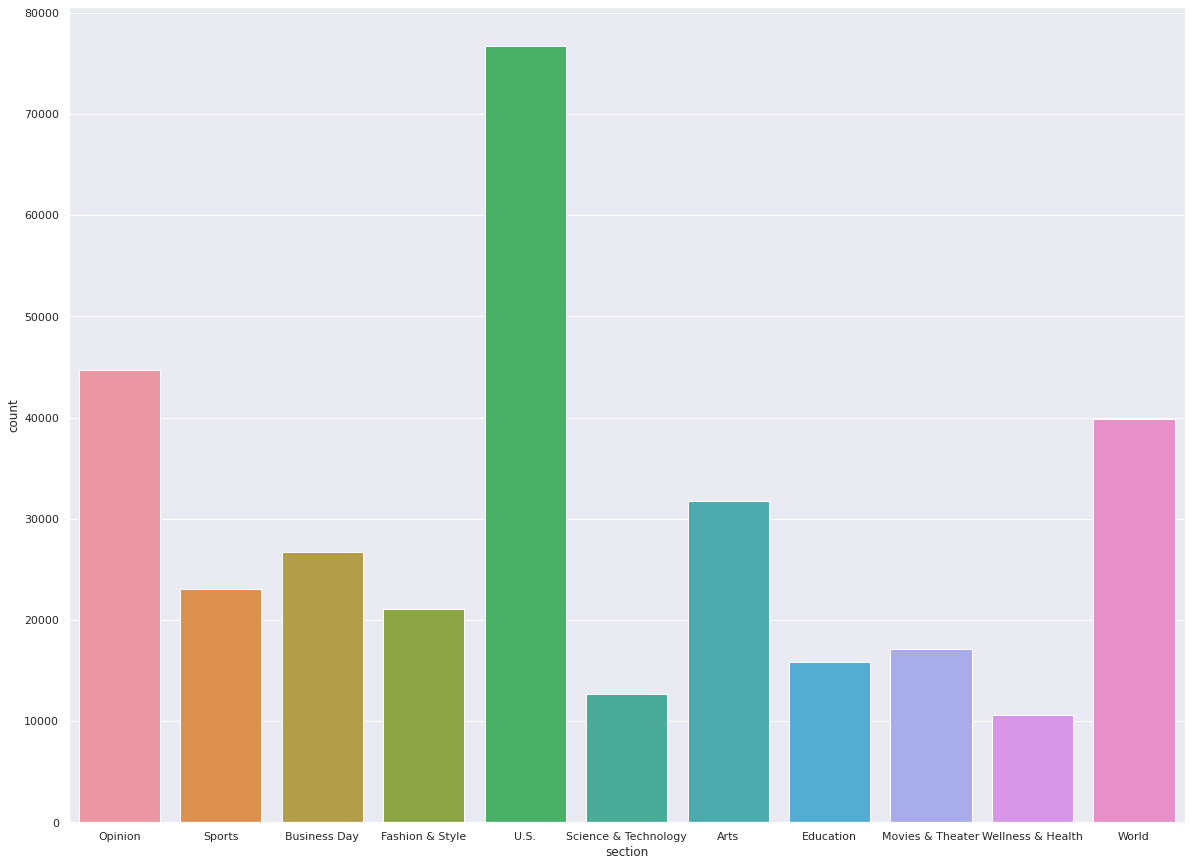

In [ ]:
sns.set(rc={'figure.figsize':(20,15)})
sns.countplot(data.section)

In [ ]:
data['news_length'] = data['headline'].str.len() + data['abstract'].str.len() + data['lead_paragraph'].str.len() + data['keywords'].str.len()
data['news_length']
data['news_length'].max()

2494

In [ ]:
data['text'] = data['headline'] + " "+ data['abstract'] + " "+ data['lead_paragraph'] +" "+ data['keywords']
data['text'][0]

'Anyone Else Want to See Trump ‘Shut Up’? Our president as a terrible toddler. When the nation looks back on the presidential debate we witnessed this week, do you think it’ll be remembered as: Presidential Election of 2020,Debates (Political),'

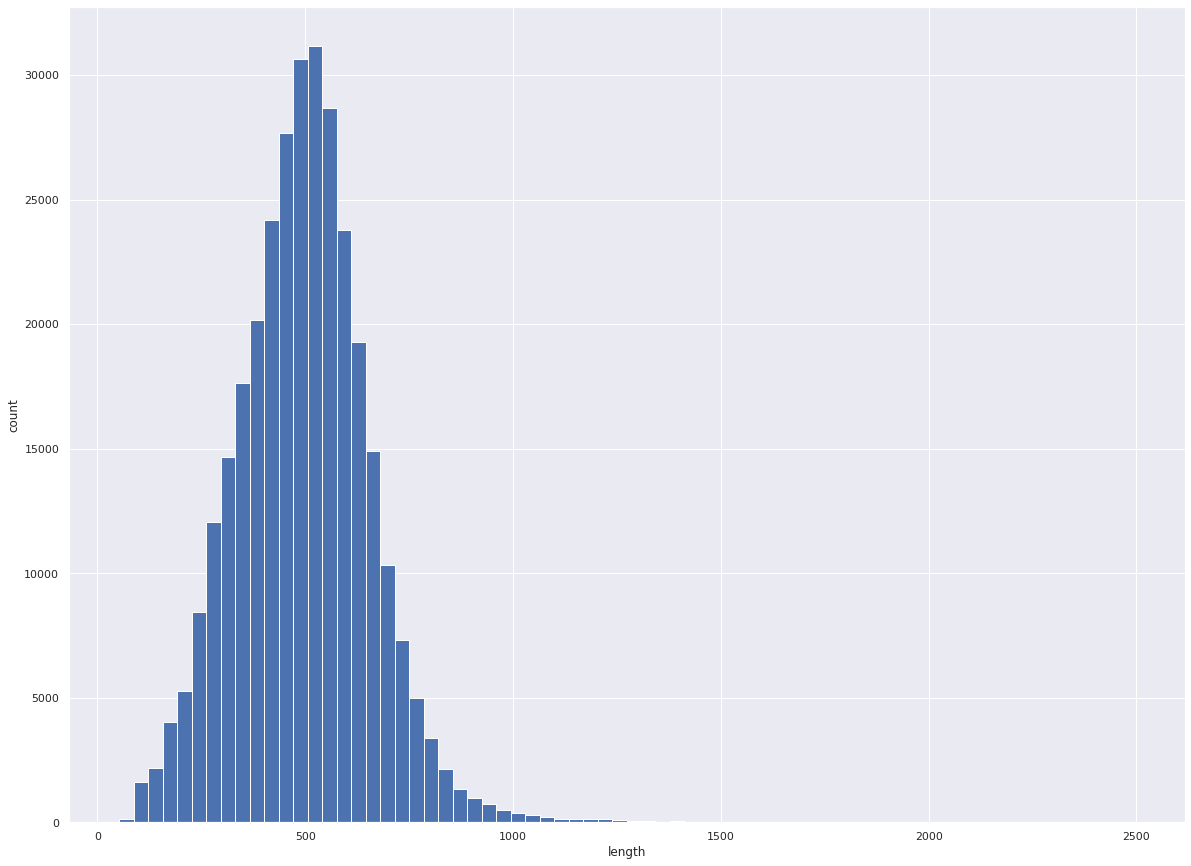

In [ ]:
sns.set()
_ = plt.hist(data['news_length'],bins=70)
_ = plt.xlabel("length")
_ = plt.ylabel("count")
plt.show()


1. OPINION



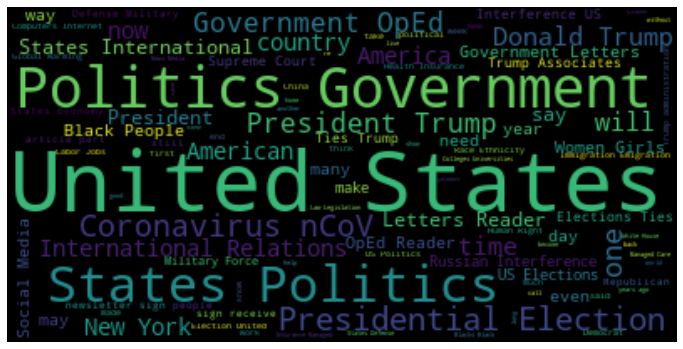


2. SPORTS



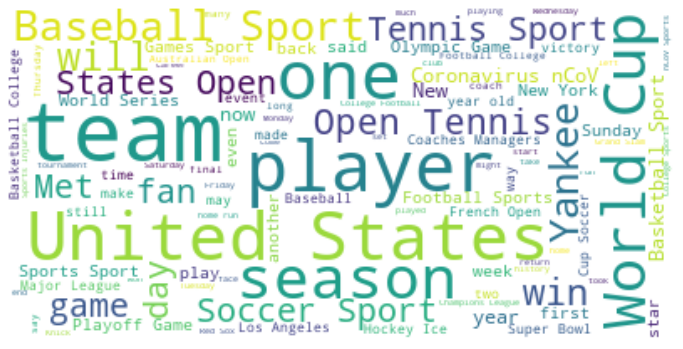


3. BUSINESS DAY



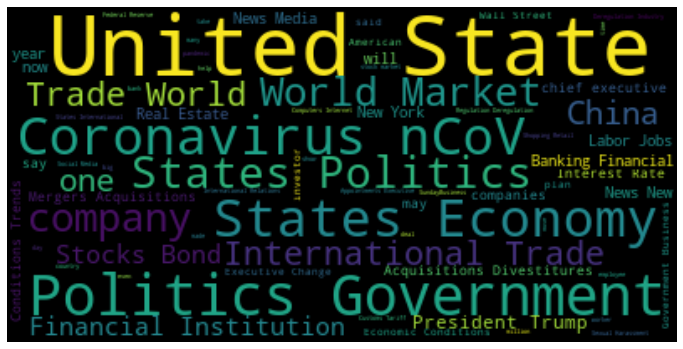


4. FASHION & STYLE



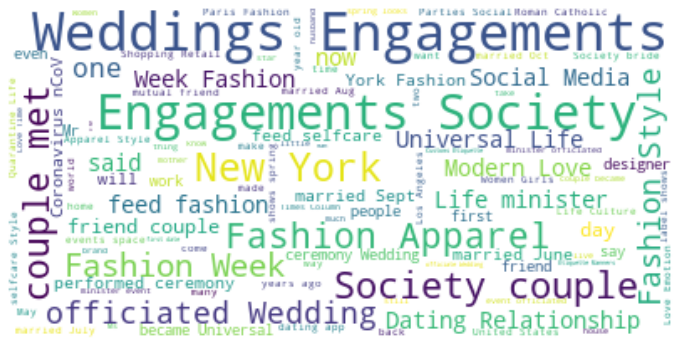


5. U.S.



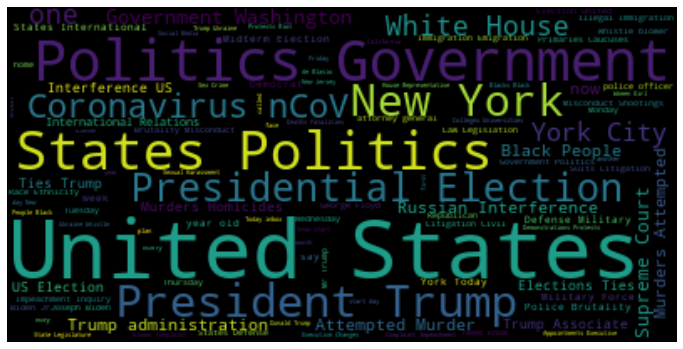


6. SCIENCE & TECHNOLOGY



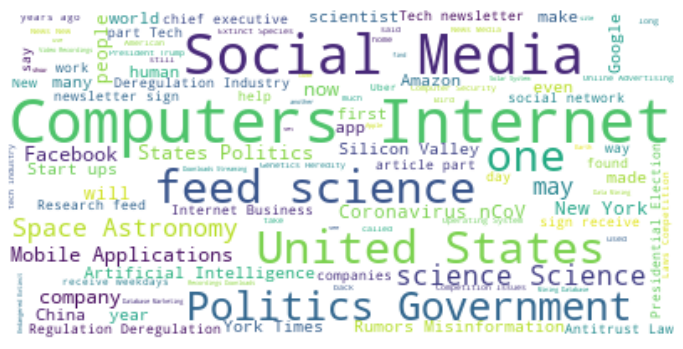


7. ARTS



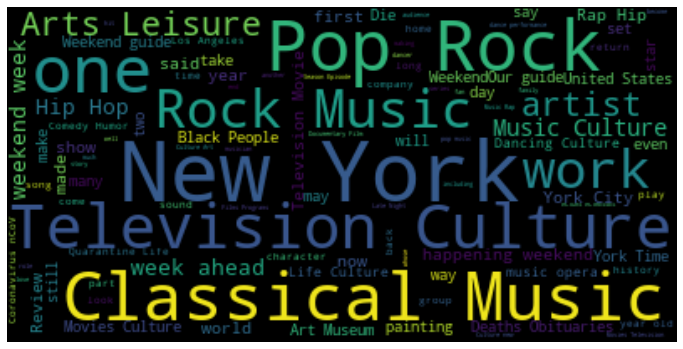


8. EDUCATION



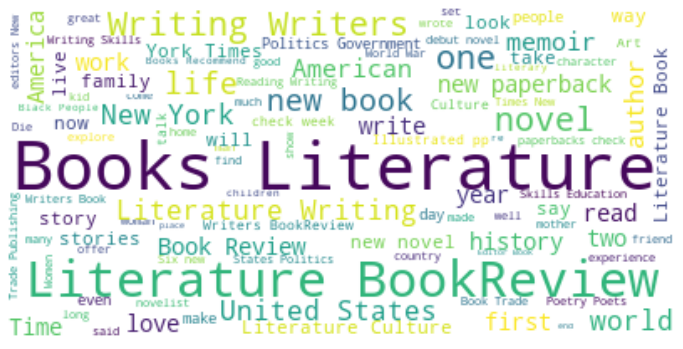


9. MOVIES & THEATER



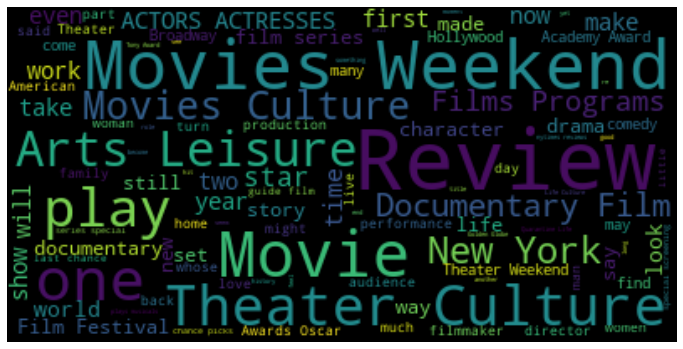


10. WELLNESS & HEALTH



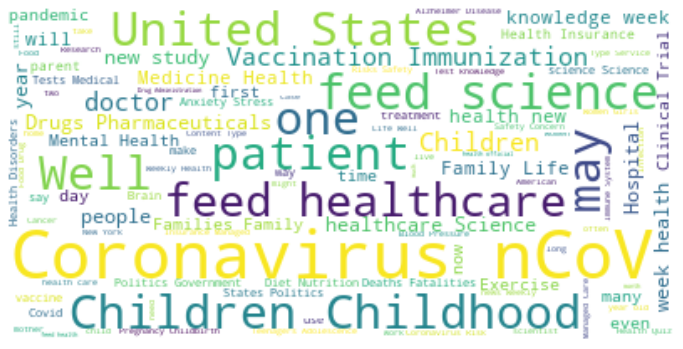


11. WORLD



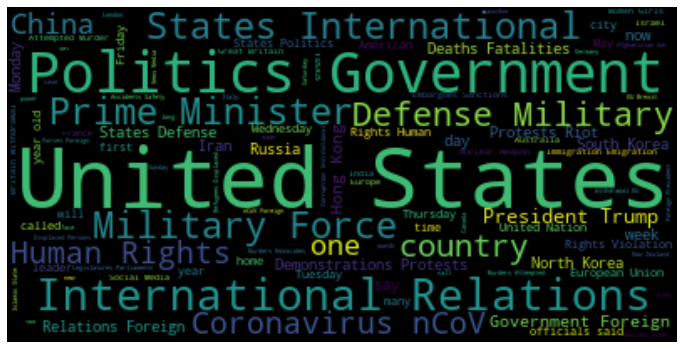

In [ ]:
categories = data['section'].unique()
i = 1
for category in categories:
  subset = data[data.section == category]
  sns.set(rc={'figure.figsize':(12,10)})
  text = subset.abstract.values + subset.headline.values + subset.lead_paragraph.values + subset.keywords.values + subset.news_desk.values
  word = ' '.join(text)
  print('\n' + str(i) + '. ' + category.upper() + '\n')
  if (i % 2 == 0):
    word_cloud(word,'white')
  else:
    word_cloud(word,'black')
  i = i + 1

In [ ]:
data['parsed_text'] = data['text'].apply(preprocess_text)
data['parsed_text'] = data['parsed_text'].apply(tokenize_stopwords)
data.head()

In [ ]:
section_codes = {'U.S.': 0,
'Arts': 1,   
'World': 2,
'Opinion': 3, 
'Business Day': 4, 
'Sports': 5,
'Fashion & Style': 6,
'Movies & Theater': 7,
'Education': 8,
'Science & Technology': 9,
'Wellness & Health': 10,
}

In [ ]:
data['section_code'] = data['section']
data = data.replace({'section_code':section_codes})

In [ ]:
print(len(data))
y = [0,1,2,3,4,5,6,7,8,9,10,11]
for x in y:
  print(data[data['section_code'] == x])
  x +=1
print(len(data))

320182
                                                 headline  ... section_code
19      For Voters Still Mulling, One Thing Is Clear: ...  ...            0
38      She Was Resting With Her Sons. Then a Shot Was...  ...            0
41      New York Becomes First Big City in U.S. to Reo...  ...            0
43      Why This Artist Is Paying Bodegas With 120,000...  ...            0
46      With Evictions Looming, Cities Revisit a Housi...  ...            0
...                                                   ...  ...          ...
449557  Trump Attacks Flynn Inquiry Amid New Revelatio...  ...            0
449558  After Decades of Service, Five Nuns Die as Vir...  ...            0
449559  Amid a Rising Death Toll, Trump Leaves the Gri...  ...            0
449562  Democrats Assail McConnell for Bringing Senate...  ...            0
449564  Scrambling the Political Divide: ‘No Normal Re...  ...            0

[76744 rows x 14 columns]
                                                 headl

In [ ]:
lstm_data = data.copy()

In [ ]:
voc_size = 1500

In [ ]:
messages = lstm_data['text'].copy()
messages = messages.reset_index(drop= True)

In [ ]:
corpus = stemming(messages)

Streaming output truncated to the last 5000 lines.
288253
288254
288255
288256
288257
288258
288259
288260
288261
288262
288263
288264
288265
288266
288267
288268
288269
288270
288271
288272
288273
288274
288275
288276
288277
288278
288279
288280
288281
288282
288283
288284
288285
288286
288287
288288
288289
288290
288291
288292
288293
288294
288295
288296
288297
288298
288299
288300
288301
288302
288303
288304
288305
288306
288307
288308
288309
288310
288311
288312
288313
288314
288315
288316
288317
288318
288319
288320
288321
288322
288323
288324
288325
288326
288327
288328
288329
288330
288331
288332
288333
288334
288335
288336
288337
288338
288339
288340
288341
288342
288343
288344
288345
288346
288347
288348
288349
288350
288351
288352
288353
288354
288355
288356
288357
288358
288359
288360
288361
288362
288363
288364
288365
288366
288367
288368
288369
288370
288371
288372
288373
288374
288375
288376
288377
288378
288379
288380
288381
288382
288383
288384
288385
288386
288387
2883

In [ ]:
corpus

['anyon els want see trump shut presid terribl toddler nation look back presidenti debat wit week think rememb presidenti elect debat polit',
 'laker beat heat game n b final laker fell deficit earli fought back string pointer heat hobbl injuri concern rest seri lebron jame accustom game like basketbal nba championship playoff game',
 'trump call extremist stand instead condemn violent group presid marshal presid trump hurt joe biden tuesday debat badli damag countri presidenti elect unit state polit govern right wing extrem alt right fring group movement white debat polit demonstr protest riot',
 'mike espi make histori democrat parti claim valu black support work harder make happen end civil war mississippi major black state black peopl black presidenti elect unit state polit govern state legislatur elect senat',
 'trump tax avoid tax rest us major taxpay afford expens profession advic success tax avoid strategi depend know donald trump recent feder incom tax return indic illeg activ

In [ ]:
totalLne = len(corpus)
i = 0
maxLen = 0
while i < totalLne:
  currentLen = len(corpus[i])
  if currentLen > maxLen:
    maxLen = currentLen
  i += 1
print(maxLen)

1489


In [ ]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr

[[1189,
  885,
  1199,
  251,
  652,
  870,
  372,
  566,
  226,
  126,
  428,
  700,
  986,
  198,
  393,
  968,
  1075,
  287,
  986,
  10,
  198,
  577],
 [108,
  1072,
  538,
  148,
  1494,
  868,
  975,
  108,
  1494,
  1319,
  483,
  1233,
  700,
  33,
  1397,
  538,
  1292,
  1025,
  328,
  580,
  1284,
  1111,
  187,
  623,
  148,
  357,
  1239,
  1316,
  1011,
  1139,
  148],
 [652,
  434,
  171,
  1440,
  810,
  585,
  1003,
  1414,
  372,
  824,
  372,
  652,
  494,
  1109,
  633,
  1472,
  198,
  1027,
  1238,
  1236,
  986,
  10,
  1094,
  822,
  577,
  1246,
  187,
  148,
  693,
  131,
  187,
  594,
  1414,
  196,
  454,
  198,
  577,
  644,
  795,
  1282],
 [848,
  1108,
  512,
  117,
  1410,
  1008,
  81,
  880,
  1074,
  1246,
  1318,
  1235,
  512,
  593,
  1205,
  434,
  34,
  78,
  537,
  1074,
  822,
  1074,
  474,
  1074,
  986,
  10,
  1094,
  822,
  577,
  1246,
  822,
  862,
  10,
  538],
 [652,
  56,
  1417,
  56,
  580,
  1242,
  537,
  1218,
  1283,
  823,
 

In [ ]:
sent_length=1500
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ...   10  198  577]
 [   0    0    0 ... 1011 1139  148]
 [   0    0    0 ...  644  795 1282]
 ...
 [   0    0    0 ...  866  781  377]
 [   0    0    0 ... 1000  638 1374]
 [   0    0    0 ... 1179   98  404]]


In [ ]:
train_label = data['section_code']
len(train_label.value_counts())

11

In [ ]:
train_label = train_label.reset_index(drop= True)

In [ ]:
print(len(train_label), len(corpus))

159915 159915


In [ ]:
embedding_dim = 64
model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(voc_size, embedding_dim),
                              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
                              tf.keras.layers.Conv1D(128, 5, activation='relu', input_shape = (None, 128, 1)),
                              tf.keras.layers.GlobalAveragePooling1D(),
                              tf.keras.layers.Dense(64,activation= 'relu'),
                              tf.keras.layers.Dropout(0.3),
                              tf.keras.layers.Dense(embedding_dim,activation= 'relu'),
                              tf.keras.layers.Dropout(0.3),
                              tf.keras.layers.Dense(11, activation= 'softmax')

])


model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          96000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         82048     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4

In [ ]:
import numpy as np
X_final=(embedded_docs)
y_final=(train_label)

In [ ]:
from sklearn.model_selection import train_test_split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_final, y_final, test_size=0.33, random_state=14)

In [ ]:
y_train_lstm.value_counts()

0     25748
3     15004
2     13340
1     10555
4      8992
5      7709
6      7040
7      5754
8      5188
9      4276
10     3537
Name: section_code, dtype: int64

In [ ]:
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(sampling_strategy={0:5000,1:5000,2:5000,3:5000, 4: 5000, 5: 5000, 6:5000, 7:5000}, random_state=10)
under.fit(X_train_lstm, y_train_lstm)
X_Under, Y_Under = under.fit_sample(X_train_lstm, y_train_lstm)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
y_test_lstm.replace('Movies & Theater', 7, inplace= True)
x_test_lstm = np.array(x_test_lstm, dtype=np.float)
y_test_lstm = np.array(y_test_lstm, dtype=np.float)


In [ ]:
model.fit(X_Under,Y_Under,validation_data=(X_test_lstm,y_test_lstm),epochs=8,batch_size=64)

Epoch 1/8
829/829 [==============================] - 148s 179ms/step - loss: 0.8228 - accuracy: 0.7495 - val_loss: 0.9079 - val_accuracy: 0.7098
Epoch 2/8
829/829 [==============================] - 148s 179ms/step - loss: 0.7461 - accuracy: 0.7789 - val_loss: 0.8563 - val_accuracy: 0.7295
Epoch 3/8
829/829 [==============================] - 149s 179ms/step - loss: 0.6817 - accuracy: 0.8010 - val_loss: 0.8624 - val_accuracy: 0.7261
Epoch 4/8
829/829 [==============================] - 149s 180ms/step - loss: 0.6395 - accuracy: 0.8163 - val_loss: 0.8113 - val_accuracy: 0.7389
Epoch 5/8
829/829 [==============================] - 149s 180ms/step - loss: 0.6024 - accuracy: 0.8260 - val_loss: 0.8021 - val_accuracy: 0.7492
Epoch 6/8
829/829 [==============================] - 148s 179ms/step - loss: 0.5699 - accuracy: 0.8358 - val_loss: 0.8343 - val_accuracy: 0.7439
Epoch 7/8
829/829 [==============================] - 149s 179ms/step - loss: 0.5366 - accuracy: 0.8461 - val_loss: 0.7854 - val_ac

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
model.save("BidirectionalLSTMLowerClasses.h5")

Implementing ML models

In [ ]:
#splitting data into test & train
X_train, X_test, y_train,y_test = train_test_split(data['parsed_text'],data['section_code'],test_size = 0.2,random_state=8)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print(X_test.shape)

(256145,)
(256145,)
(64037,)
(64037,)


In [ ]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 5000

In [ ]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range = ngram_range,
                        stop_words = None,
                        lowercase = False,
                        max_df = max_df,
                        min_df = min_df,
                        max_features = max_features,
                        norm = 'l2',
                        sublinear_tf = True
                        )
train_features = tfidf.fit_transform(X_train).toarray()
train_label = y_train

test_features = tfidf.transform(X_test).toarray()
test_label = y_test

In [ ]:
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(sampling_strategy={0:5000,1:5000,2:5000,3:5000, 4: 5000, 5: 5000, 6:5000, 7:5000}, random_state=10)
#under.fit(train_features, train_label)
train_features, train_label = under.fit_sample(train_features, train_label)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(test_label.shape)
print(train_label.shape)
print(train_features.shape)
print(test_features.shape)
# train_features.sum()

(64037,)
(71406,)
(71406, 5000)
(64037, 5000)


##Random Forest Model

In [ ]:
model = RandomForestClassifier()
model.fit(train_features,train_label)
predictions = model.predict(test_features)
print(accuracy_score(test_label,predictions))
print(classification_report(test_label,predictions))

0.7553289504505208
              precision    recall  f1-score   support

           0       0.85      0.69      0.76     15459
           1       0.85      0.81      0.83      6354
           2       0.71      0.76      0.74      8007
           3       0.80      0.51      0.62      8866
           4       0.73      0.66      0.69      5257
           5       0.85      0.95      0.89      4658
           6       0.89      0.78      0.83      4263
           7       0.79      0.94      0.86      3379
           8       0.79      0.99      0.88      3100
           9       0.52      0.97      0.68      2586
          10       0.41      0.97      0.58      2108

    accuracy                           0.76     64037
   macro avg       0.75      0.82      0.76     64037
weighted avg       0.78      0.76      0.76     64037



In [ ]:
print(accuracy_score(test_label,predictions))
print(classification_report(test_label,predictions))

0.4848915470743476
              precision    recall  f1-score   support

           0       0.79      0.38      0.51     15459
           1       0.87      0.50      0.64      6354
           2       0.74      0.24      0.37      8007
           3       0.77      0.36      0.49      8866
           4       0.82      0.15      0.25      5257
           5       0.82      0.85      0.84      4658
           6       0.91      0.59      0.71      4263
           7       0.69      0.87      0.77      3379
           8       0.65      0.96      0.78      3100
           9       0.10      0.87      0.18      2586
          10       0.26      0.75      0.39      2108

    accuracy                           0.48     64037
   macro avg       0.68      0.59      0.54     64037
weighted avg       0.74      0.48      0.53     64037



##Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(train_features,train_label)
predictions = model.predict(test_features)
print(accuracy_score(test_label,predictions))
print(classification_report(test_label,predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7874197729437669
              precision    recall  f1-score   support

           0       0.88      0.75      0.81     15459
           1       0.86      0.82      0.84      6354
           2       0.81      0.81      0.81      8007
           3       0.78      0.61      0.69      8866
           4       0.72      0.70      0.71      5257
           5       0.91      0.94      0.93      4658
           6       0.83      0.79      0.81      4263
           7       0.84      0.91      0.88      3379
           8       0.83      0.97      0.89      3100
           9       0.50      0.89      0.64      2586
          10       0.46      0.91      0.61      2108

    accuracy                           0.79     64037
   macro avg       0.77      0.83      0.78     64037
weighted avg       0.81      0.79      0.79     64037



# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(train_features,train_label)
predictions = model.predict(test_features)
print(accuracy_score(test_label,predictions))
print(classification_report(test_label,predictions))

0.6705966862907382
              precision    recall  f1-score   support

           0       0.77      0.55      0.64     15459
           1       0.76      0.71      0.74      6354
           2       0.62      0.59      0.61      8007
           3       0.60      0.51      0.55      8866
           4       0.54      0.59      0.56      5257
           5       0.80      0.85      0.83      4658
           6       0.72      0.76      0.74      4263
           7       0.77      0.86      0.82      3379
           8       0.81      0.98      0.89      3100
           9       0.51      0.93      0.66      2586
          10       0.45      0.93      0.60      2108

    accuracy                           0.67     64037
   macro avg       0.67      0.75      0.69     64037
weighted avg       0.69      0.67      0.67     64037



# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(train_features,train_label)
predictions = model.predict(test_features)
print(accuracy_score(test_label,predictions))
print(classification_report(test_label,predictions))
#print(predictions)

0.5747458500554367
              precision    recall  f1-score   support

           0       0.83      0.50      0.62     15459
           1       0.74      0.42      0.53      6354
           2       0.63      0.77      0.69      8007
           3       0.73      0.26      0.38      8866
           4       0.62      0.46      0.52      5257
           5       0.61      0.92      0.73      4658
           6       0.56      0.72      0.63      4263
           7       0.33      0.87      0.48      3379
           8       0.73      0.68      0.71      3100
           9       0.42      0.57      0.48      2586
          10       0.26      0.85      0.40      2108

    accuracy                           0.57     64037
   macro avg       0.59      0.64      0.56     64037
weighted avg       0.67      0.57      0.57     64037



In [ ]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100,300,500,800]
max_depth = [5,10,15,25]
min_samples_split = [2,5,10,15,20]
min_samples_leaf = [1,2,5,10]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
hyperF

{'max_depth': [5, 10, 15, 25],
 'min_samples_leaf': [1, 2, 5, 10],
 'min_samples_split': [2, 5, 10, 15, 20],
 'n_estimators': [100, 300, 500, 800]}

In [ ]:
hyperF.bes

In [ ]:
model = RandomForestClassifier()
# rfModel = GridSearchCV(model,hyperF,cv=3,verbose=1)
# bestF = gridF.fit(train_features, train_label)
model.fit()

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
